## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import spark_fof

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

In [4]:
import spark_fof_c

## Set up data

In [5]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [6]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 1000000
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*1.7 - 0.85
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.002,0,0],[0,.002,0],[0,0,.002]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

## Start Spark

In [7]:
import findspark
findspark.init()

In [8]:
import pyspark
from pyspark import SparkContext, SparkConf

In [9]:
conf = SparkConf()

In [10]:
import os

In [11]:
os.environ['SPARK_DRIVER_MEMORY']= '4G'

In [12]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [13]:
sc = SparkContext(master='local[4]', conf=conf, batchSize=0)

In [14]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [15]:
N = 4
tau = 0.05
mins = np.array([-1,-1,-1], dtype=np.float)
maxs= np.array([1,1,1], dtype=np.float)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

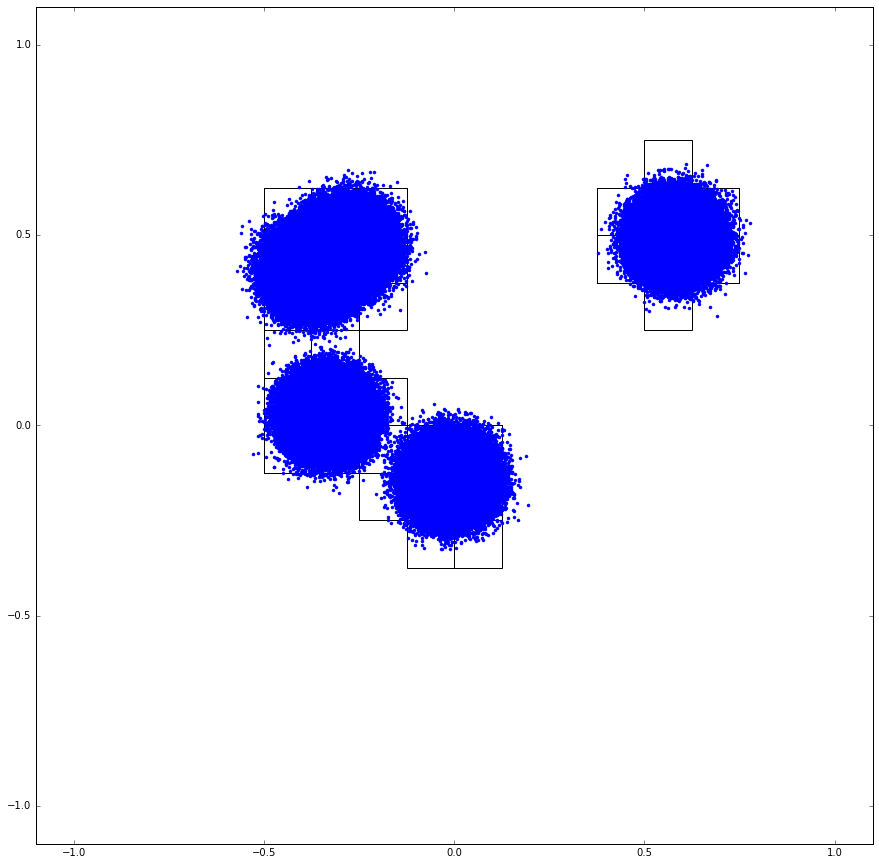

In [16]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000]: 
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'],2**N, np.array(mins), np.array(maxs))], ax=ax)
#    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
# for r in domain_containers: 
#     plot_rectangle(r.parent, ax=ax)
ax.plot(particles['pos'][:,0], particles['pos'][:,1], '.')

### Make the base RDD

In [ ]:
p_rdd = sc.parallelize(particles)

### Partition particles into domains and set the partition part of local group ID

In [ ]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values())

In [ ]:
part_rdd.count()

In [ ]:
p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles(particles, domain_containers, tau)).count()

In [ ]:
sc.show_profiles()

In [16]:
import cython

In [17]:
%load_ext Cython

In [18]:
point = np.array([.5,.5,.5], dtype=np.float32)
r = domain_containers[spark_fof.get_bin_cython(point, 2**N, mins, maxs)]

In [19]:
%timeit spark_fof_c.in_rectangle_cython(mins, maxs, point)

The slowest run took 7.88 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.27 µs per loop


In [20]:
%timeit r.min_distance_point(point)

The slowest run took 10.69 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.99 µs per loop


In [21]:
list(spark_fof_c.partition_particles_cython(particles[:1000], domain_containers, tau))

[(2376,
  ([0.046412013471126556, -0.3877680003643036, 0.16156107187271118], 0, 0)),
 (2376,
  ([0.00832896027714014, -0.4095199406147003, 0.17355036735534668], 0, 1)),
 (2136,
  ([0.04915374144911766, -0.32111603021621704, 0.06907016038894653], 0, 2)),
 (2392,
  ([0.05301889777183533, -0.34260520339012146, 0.2119373232126236], 0, 3)),
 (2408,
  ([0.033369917422533035, -0.23577187955379486, 0.20771512389183044], 0, 4)),
 (2375,
  ([-0.02550102025270462, -0.4101140797138214, 0.12816160917282104], 0, 5)),
 (2391,
  ([-0.003866862738505006, -0.3111719489097595, 0.20579120516777039], 0, 6)),
 (2391,
  ([-0.03127863258123398, -0.2592962980270386, 0.14784227311611176], 0, 7)),
 (2392,
  ([0.040467239916324615, -0.36408278346061707, 0.18135075271129608], 0, 8)),
 (2119,
  ([-0.09535230696201324, -0.41159582138061523, 0.10277197510004044], 0, 9)),
 (2391,
  ([-0.025517325848340988, -0.2960207462310791, 0.14241169393062592], 0, 10)),
 (2391,
  ([-0.05413847416639328, -0.3302759528160095, 0.1677

In [122]:
%%timeit ps = particles[:100000]
for x in spark_fof_c.partition_particles_cython(ps, domain_containers, tau): pass

1 loop, best of 3: 1.05 s per loop


In [123]:
%%timeit ps = particles[:100000]
for x in spark_fof.partition_particles(ps, domain_containers, tau): pass

1 loop, best of 3: 4.1 s per loop


In [23]:
%load_ext Cython

In [129]:
%%cython
#cython: profile=True
import cython
cimport cython

import numpy as np
cimport numpy as np

import spark_fof_c
import spark_fof

pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])

cdef struct Particle:
    float pos[3]
    int iGroup
    int iOrder

def check(particles): 
    cdef Particle point

    p_arr = np.fromiter(particles, pdt)
    
    cdef Particle [:] arr = p_arr
    
    for i in range(10): 
        print arr[i].pos, type(p_arr[i]['pos'])
        
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False) 
def partition_particles_cython(particles, domain_containers, tau):
    """Copy particles in buffer areas to the partitions that will need them"""
    cdef int N = domain_containers[0].N
    cdef int nparts 

    p_arr = np.fromiter(particles, pdt)
    nparts = len(p_arr)
    
    trans = np.array([[-tau, 0, 0], [0,-tau, 0], [0, 0, -tau], [-tau, -tau, 0], [0, -tau, -tau], [-tau,-tau,-tau]])

    dom_mins = np.array([-1.,-1.,-1.])
    dom_maxs = np.array([1., 1., 1.])

    for i in range(nparts):
        point = p_arr['pos'][i]
        my_bins = []
        my_bins.append(spark_fof.get_bin_cython(point, 2**N, dom_mins, dom_maxs))

        my_rect = domain_containers[my_bins[0]]

        if spark_fof.rect_buffer_zone_cython(point, domain_containers):
            # particle coordinates in single array
            coords = np.copy(point)
            # iterate through the transformations
            for t in trans: 
                #x,y,z = coords + t
                trans_bin = spark_fof.get_bin_cython(coords+t, 2**N, dom_mins,dom_maxs)
                if trans_bin not in my_bins and trans_bin > 0:
                    my_bins.append(trans_bin)
                    yield (trans_bin, p_arr[i])

        # return the first bin, i.e. the only non-ghost bin
        yield (my_bins[0], p_arr[i])

In [106]:
%load_ext line_profiler

In [130]:
%%timeit ps = particles[:100000]
for x in partition_particles_cython(ps, domain_containers, tau): pass

1 loop, best of 3: 4.09 s per loop


In [117]:
%%timeit ps = particles[:100000]
for x in spark_fof.partition_particles(ps, domain_containers, tau): pass

1 loop, best of 3: 4.07 s per loop


In [114]:
%%prun ps = particles[:100000]
for x in partition_particles_cython(ps, domain_containers, tau): pass

In [115]:
%%prun ps = particles[:100000]
for x in spark_fof.partition_particles(ps, domain_containers, tau): pass

### Run the local FOF

In [ ]:
from spark_util import spark_cython

In [ ]:
run_fof = spark_cython('fof', 'run')

In [ ]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        run_fof(part_arr, tau)
    part_arr['iOrder'] = index
    return part_arr

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        gid = part_arr[i]['iGroup']
        part_arr[i]['iGroup'] = spark_fof.encode_gid(partition_index, gid, 16)
    return part_arr

In [ ]:
part_rdd.mapPartitionsWithIndex(run_local_fof).collect()

In [ ]:
sc.show_profiles()

In [ ]:
fof_rdd = part_rdd.mapPartitions(run_local_fof).mapPartitionsWithIndex(set_group_id)

In [ ]:
fof_rdd.take(10)

### Group Merging stage

In [ ]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [ ]:
merged_rdd = fof_analyzer.merge_groups(0)

In [ ]:
merged_rdd.collect()

In [ ]:
sc.show_profiles()

In [ ]:
p_arr = np.array(fof_analyzer.particle_rdd.collect())

In [ ]:
groups = np.unique(p_arr['gid'])

In [ ]:
for g in groups:
    inds = np.where(p_arr['gid'] == g)
    if g in m.keys():
        p_arr['gid'][inds] = m[g]

In [ ]:
p_arr

In [ ]:
def remap_gid_partition(particles, gid_map):
    p_arr = np.fromiter(particles, spark_fof.pdt)
    groups = np.unique(p_arr['gid'])
    for g in groups:
        inds = np.where(p_arr['gid'] == g)
        if g in gid_map.keys():
            p_arr['gid'][inds] = gid_map[g]
    return p_arr

In [ ]:
ps = fof_analyzer.particle_rdd.collect()

In [ ]:
fof_analyzer.particle_rdd.collect()

## try get_bin with cython

In [ ]:
import numpy as np
# import pyximport
# pyximport.install(setup_args={"include_dirs":np.get_include()},
#                   reload_support=True)

In [ ]:
xs = np.random.rand(1000000)
ys = np.random.rand(1000000)

### Setup cython on workers

looks like some helpful info here: https://www.4info.com/Blog/October-2014/Enhancing-Spark-with-IPython-Notebook-and-Cython

In [ ]:
sc.addPyFile('spark_fof_c.pyx')
sc.addPyFile('spark_util.py')

In [ ]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()})   

In [ ]:
from spark_util import spark_cython

In [ ]:
def get_particle_bin(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p.x,p.y,100,-1,-1,1,1)

def get_particle_bin_numpy(p):
    from spark_util import spark_cython
    return spark_cython('spark_fof_c', 'get_bin_cython')(p['x'],p['y'],100,-1,-1,1,1)

def get_particle_bin_partition(particles, n):
    xs = np.zeros(n)
    ys = np.zeros(n)
    bins = np.zeros(n, dtype=np.int32)
    
    for i, p in enumerate(particles): 
        xs[i]=p.x
        xs[i]=p.y
    
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(xs,ys,bins)
    
    for bin in bins: yield bin

def get_particle_bin_partition_numpy(particles): 
    p_arr = np.fromiter(particles, pdt)
    bins = np.zeros(len(p_arr), dtype=np.int)
    spark_cython('spark_fof_c', 'get_particle_bins_cython')(p_arr['x'], p_arr['y'], bins)
    return bins

def get_particle_bin_python(p):
    return get_bin(p['x'],p['y'],100,[-1,-1],[1,1])

In [ ]:
pdt = np.dtype([('x','f8'), ('y','f8')])

p_np_arr = np.zeros(10000000,dtype=pdt)

for i in range(len(p_np_arr)):
    p_np_arr[i] = np.random.rand(2)

In [ ]:
#p_arr_rdd = sc.parallelize(p_arr).cache()
p_np_arr_rdd = sc.parallelize(p_np_arr).cache()

In [ ]:
p_np_arr_rdd.count()

In [ ]:
%time p_np_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

In [ ]:
sc.show_profiles()

In [ ]:
import cPickle as pickle
class PickleSerializer2(pyspark.serializers.FramedSerializer):

    """
    Serializes objects using Python's pickle serializer:

        http://docs.python.org/2/library/pickle.html

    This serializer supports nearly any Python object, but may
    not be as fast as more specialized serializers.
    """

    def dumps(self, obj):
        return pickle.dumps(obj, protocol)

    if sys.version >= '3':
        def loads(self, obj, encoding="bytes"):
            return pickle.loads(obj, encoding=encoding)
    else:
        def loads(self, obj, encoding=None):
            print 'object size', len(obj)
            return pickle.loads(obj)


In [ ]:
class NumpySerializer(pyspark.serializers.FramedSerializer):
    import numpy as np
    
    def __init__(self, dtype): 
        self.dtype = dtype
        super(NumpySerializer, self).__init__()
    
    def dumps(self, obj):
        print 'SERIALIZING'
        return obj.tobytes()
    def loads(self, obj):
        print 'string length: ', len(obj)
        return np.fromstring(obj, dtype=self.dtype)
    
    def _read_with_length(self, stream):
        length = pyspark.serializers.read_int(stream)
        print 'stream length: ', length
        if length == pyspark.serializers.SpecialLengths.END_OF_DATA_SECTION:
            raise EOFError
        elif length == pyspark.serializers.SpecialLengths.NULL:
            return None
        obj = stream.read(length)
        if len(obj) < length:
            raise EOFError
        return self.loads(obj)
    

In [ ]:
ns = NumpySerializer(pdt)

In [ ]:
new_arr_rdd = p_np_arr_rdd._reserialize(pyspark.serializers.BatchedSerializer(NumpySerializer(pdt), 1024))

In [ ]:
new_arr_rdd._jrdd_deserializer

In [ ]:
p_np_arr_rdd._jrdd_deserializer = NumpySerializer(pdt)

In [ ]:
p_np_arr_rdd.count()

In [ ]:
%timeit pickle.dumps(p_np_arr)

In [ ]:
%timeit p_np_arr.tostring()

In [ ]:
%time new_arr_rdd.mapPartitions(get_particle_bin_partition_numpy).count()

In [ ]:
ps = new_arr_rdd.count()

In [ ]:
sc.show_profiles()

In [ ]:
bin(1 << 32)

In [ ]:
bin(1) 

In [ ]:
bin(101)

In [ ]:
2**32

In [ ]:
x = np.binary_repr(1, width=32)

In [ ]:
y = np.binary_repr(1, width=32)

In [ ]:
int(x+y,2)

In [ ]:
np.binary_repr(int(x+y,2), width=64)

In [ ]:
# encode a 32-bit partition ID (pid) and 32-bit cluster ID (cid) into one 64-bit integer
encode_gid = lambda pid, cid: np.int64(int(np.binary_repr(pid,width=32)+np.binary_repr(cid,width=32),2))